In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import json
import numpy as np
import pickle as pickle_
import csv
import os
import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [2]:
df = pd.read_csv("part6.csv")

In [3]:
data = df[['title','location']]

In [4]:
data.head(20)

,title,location
0,I'm so excited the road to #SuperBowlXLIX will...,#Seahawks #Mariners
1,At http://t.co/Vd0RWOeAed -- #Seahawks #12thMA...,NaN
2,You been 12ed pass it on #SeahawkNation #LOB #...,k-town Ak.
3,27 days to the SuperBowl 🏈🏈\n#Katyperry #KatyC...,Brazil
4,Check out the cool event that #budlight has p...,Iowa
5,#SuperBowl2015 #Halftime 🏈🎉 http://t.co/qk8Wew...,http://ask.fm/lKatzPerryl
6,Lenny Kravitz acompañará a Katy Perry en el #H...,Cloud 9
7,#AlertaQRP NFL anuncia que Katy Perry estará a...,LATINOAMÉRICA
8,So this official OMG Super Bowl #prediction \n...,Westcoast right near da beach
9,Our @ButchStearns talked #Patriots w/3X #Super...,"Boston, MA"


In [5]:
print(data.shape)

(1348761, 2)


In [25]:
wash_list = ["seattle", "washington","wa","kirkland", "redmond", "bellevue", "tacoma","spokane","olympia"]
not_wash = ["dc","d.c."]
mass_list = ["ma","massachusetts","boston","worcester","salem","plymouth","springfield","arlington","scituate","northampton"]
not_mass = ["ohio","oh"]

In [26]:
def check_wash(loc):
    flag = False
    locs = loc.lower().split()
    for word in wash_list:
        if word in locs:
            flag = True
            break
            
    for word in not_wash:
        if word in locs:
            flag = False
            break
    return flag

def check_mass(loc):
    flag = False
    locs = loc.lower().split()
    for word in mass_list:
        if word in locs:
            flag = True
            break
            
    for word in not_mass:
        if word in locs:
            flag = False
            break
    return flag

In [27]:
tweet=[]
location=[]
for i in range(0,data.shape[0]):
    str1 = str(data['location'][i])
    if check_wash(str1) == True :
        tweet.append(data['title'][i])
        location.append(0)
    elif check_mass(str1) == True :
        tweet.append(data['title'][i])
        location.append(1)

In [28]:
print(np.unique(location, return_counts = True))

(array([0, 1]), array([19161, 21744], dtype=int64))


In [29]:
def tokenize(data):
    data = re.sub('[,.-:/()?{}*$#&]', ' ', data)
    # Convert list data to string
    raw = "".join(doc for doc in data)
    raw = "".join(ch for ch in raw if ord(ch) < 128)
    # Split into words
    tokens = word_tokenize(raw)
    # Convert to lower case
    tokens = [w.lower() for w in tokens]
    # Remove punctuation and keep on alphanumeric tokens
    punctuations = list(string.punctuation)
    punctuations.append("''")
    words = [word for word in tokens if word not in punctuations]
    words = [word for word in words if word.isalnum()]
    # Filter out stopwords
    stop_words = text.ENGLISH_STOP_WORDS
    words = [w for w in words if not w in stop_words]
    # Stemming
    stemmer = SnowballStemmer("english")
    stemmed = [stemmer.stem(word) for word in words]
    return stemmed  

In [30]:
def getLSI(df, X_train,X_test):
    print("Min df: ", df)
    vectorizer = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    X_train_counts = vectorizer.fit_transform(X_train)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    print("Training Set TFIDF shape: ", X_train_tfidf.shape)
    X_test_counts = vectorizer.transform(X_test)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    print("Test Set TFIDF shape: ", X_test_tfidf.shape)
    svd = TruncatedSVD(n_components=50, n_iter=7, random_state=42)
    svd_train = svd.fit_transform(X_train_tfidf)
    svd_test = svd.transform(X_test_tfidf)
    print("After SVD : ")
    print("Training Set TFIDF shape: ", svd_train.shape)
    print("Test Set TFIDF shape: ", svd_test.shape)
    print("------------------------")
    return svd_train, svd_test

In [31]:
def getNMF(df, X_train,X_test):
    print("\nMin df: ", df)
    vect = CountVectorizer(analyzer="word", tokenizer=tokenize, min_df=df, stop_words="english")
    X_train_counts = vect.fit_transform(X_train)
    X_test_counts = vect.transform(X_test)
    tfidf_transformer = TfidfTransformer(smooth_idf=False)
    X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
    X_test_tfidf = tfidf_transformer.transform(X_test_counts)
    print("Training Set TFIDF shape: ", X_train_tfidf.shape)
    print("Test Set TFIDF shape: ", X_test_tfidf.shape)
    nmf = NMF(n_components=50, init='random', random_state=42)
    nmf_train = nmf.fit_transform(X_train_tfidf)
    nmf_test = nmf.transform(X_test_tfidf)
    print("After NMF : ")
    print("Training Set TFIDF shape: ", nmf_train.shape)
    print("Test Set TFIDF shape: ", nmf_test.shape)
    print("------------------------")
    return nmf_train, nmf_test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(tweet, location, test_size=0.1, random_state=0)

In [33]:
svd_train_2,svd_test_2 = getLSI(2,X_train,X_test)
svd_train_5,svd_test_5 = getLSI(5,X_train,X_test)

Min df:  2
Training Set TFIDF shape:  (36814, 10473)
Test Set TFIDF shape:  (4091, 10473)
After SVD : 
Training Set TFIDF shape:  (36814, 50)
Test Set TFIDF shape:  (4091, 50)
------------------------
Min df:  5
Training Set TFIDF shape:  (36814, 4702)
Test Set TFIDF shape:  (4091, 4702)
After SVD : 
Training Set TFIDF shape:  (36814, 50)
Test Set TFIDF shape:  (4091, 50)
------------------------


In [34]:
nmf_train_2,nmf_test_2 = getNMF(2,X_train,X_test)
nmf_train_5,nmf_test_5 = getNMF(5,X_train,X_test)


Min df:  2
Training Set TFIDF shape:  (36814, 10473)
Test Set TFIDF shape:  (4091, 10473)
After NMF : 
Training Set TFIDF shape:  (36814, 50)
Test Set TFIDF shape:  (4091, 50)
------------------------

Min df:  5
Training Set TFIDF shape:  (36814, 4702)
Test Set TFIDF shape:  (4091, 4702)
After NMF : 
Training Set TFIDF shape:  (36814, 50)
Test Set TFIDF shape:  (4091, 50)
------------------------


In [35]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    
def performance_metrics(y_pred, y_test, y_score, categories=["Washington", "Massachusetts"], normalization=True):
    print("Precision Score: ", precision_score(y_test, y_pred))
    print("Recall Score: ", recall_score(y_test, y_pred))
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    plot_confusion_matrix(confusion_matrix(y_test, y_pred), categories, normalization)
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr,tpr, roc_auc)

### SVM Classifier

In [36]:
def perform_SVM(title,X_train,y_train,X_test,y_test):
    print(title)
    parameters = {'C':[0.0001,0.001,0.01,0.1,1,10,100,1000]}
    clf = GridSearchCV(LinearSVC(), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    svc = LinearSVC(C=best_param)
    svc.fit(X_train,y_train)
    preds = svc.predict(X_test)
    y_score = svc.decision_function(X_test)
    performance_metrics(preds,y_test,y_score)

LSI with Min df = 2
Best Parameter :  {'C': 100}
Precision Score:  0.733120113717
Recall Score:  0.943301326017
Accuracy Score:  0.786115864092
Normalized confusion matrix
[[ 0.60556723  0.39443277]
 [ 0.05669867  0.94330133]]


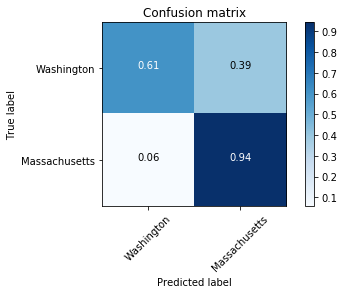

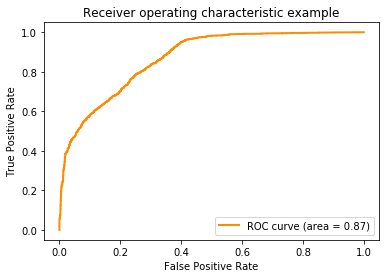

LSI with Min df = 5
Best Parameter :  {'C': 1}
Precision Score:  0.732389380531
Recall Score:  0.946044810242
Accuracy Score:  0.786360303104
Normalized confusion matrix
[[ 0.60294118  0.39705882]
 [ 0.05395519  0.94604481]]


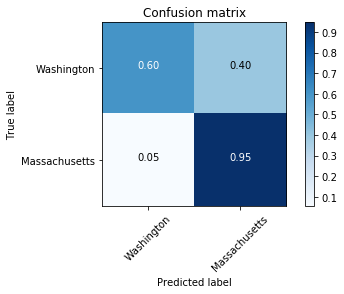

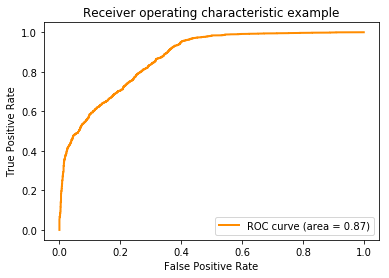

NMF with Min df = 2
Best Parameter :  {'C': 100}
Precision Score:  0.732009925558
Recall Score:  0.944215820759
Accuracy Score:  0.785382547055
Normalized confusion matrix
[[ 0.60294118  0.39705882]
 [ 0.05578418  0.94421582]]


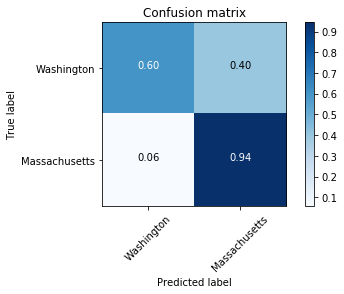

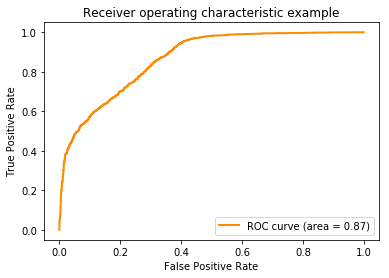

NMF with Min df = 5
Best Parameter :  {'C': 0.1}
Precision Score:  0.728706624606
Recall Score:  0.950617283951
Accuracy Score:  0.784404791005
Normalized confusion matrix
[[ 0.59348739  0.40651261]
 [ 0.04938272  0.95061728]]


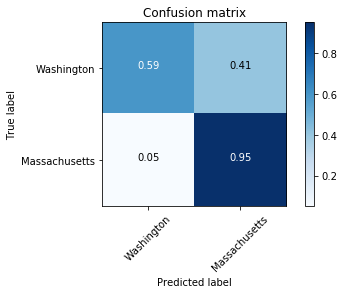

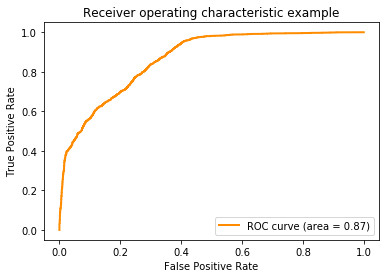

In [37]:
perform_SVM("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test)
perform_SVM("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test)
perform_SVM("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test)
perform_SVM("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test)

### Logistic Regression

#### L1 Norm

In [38]:
def perform_LR(title,X_train,y_train,X_test,y_test,penalty_):
    print(title)
    parameters = {'C':[0.001,0.01,0.1,1,10,100,1000]}
    clf = GridSearchCV(LogisticRegression(penalty=penalty_), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    lr = LogisticRegression(penalty=penalty_,C=best_param)
    lr.fit(X_train,y_train)
    preds = lr.predict(X_test)
    y_score = lr.predict_proba(X_test)
    performance_metrics(preds,y_test,y_score[:,1])

LSI with Min df = 2
Best Parameter :  {'C': 1}
Precision Score:  0.733689839572
Recall Score:  0.941015089163
Accuracy Score:  0.785871425079
Normalized confusion matrix
[[ 0.60766807  0.39233193]
 [ 0.05898491  0.94101509]]


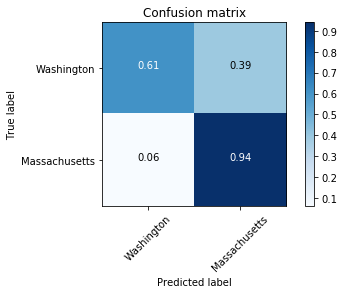

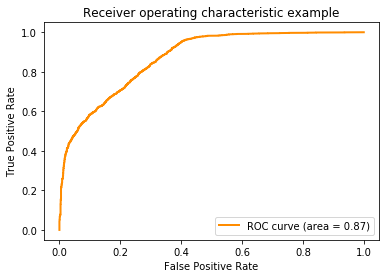

LSI with Min df = 5
Best Parameter :  {'C': 100}
Precision Score:  0.73483226267
Recall Score:  0.941472336534
Accuracy Score:  0.787093620142
Normalized confusion matrix
[[ 0.60976891  0.39023109]
 [ 0.05852766  0.94147234]]


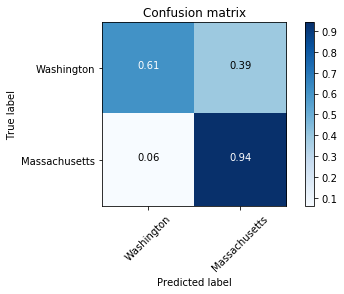

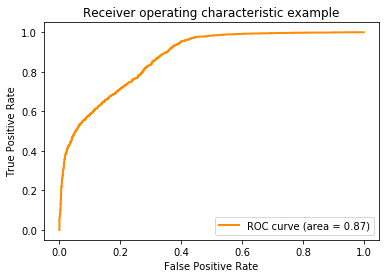

NMF with Min df = 2
Best Parameter :  {'C': 1000}
Precision Score:  0.733879586747
Recall Score:  0.941929583905
Accuracy Score:  0.786360303104
Normalized confusion matrix
[[ 0.60766807  0.39233193]
 [ 0.05807042  0.94192958]]


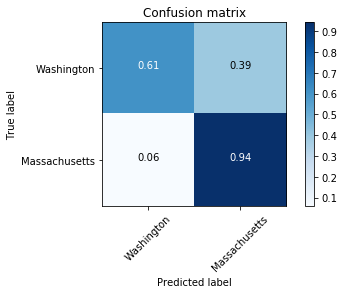

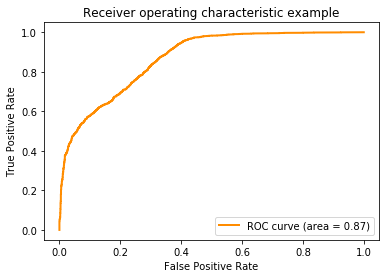

NMF with Min df = 5
Best Parameter :  {'C': 1}
Precision Score:  0.732314255244
Recall Score:  0.941929583905
Accuracy Score:  0.78489366903
Normalized confusion matrix
[[ 0.60451681  0.39548319]
 [ 0.05807042  0.94192958]]


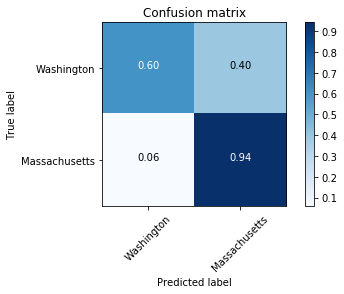

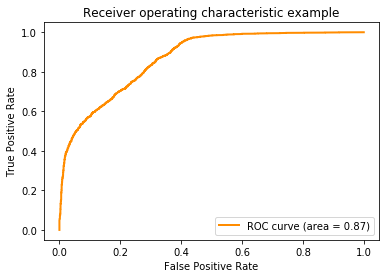

In [39]:
perform_LR("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test,'l1')
perform_LR("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test,'l1')
perform_LR("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test,'l1')
perform_LR("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test,'l1')

#### L2 Norm

LSI with Min df = 2
Best Parameter :  {'C': 100}
Precision Score:  0.734190782422
Recall Score:  0.939643347051
Accuracy Score:  0.785871425079
Normalized confusion matrix
[[ 0.6092437   0.3907563 ]
 [ 0.06035665  0.93964335]]


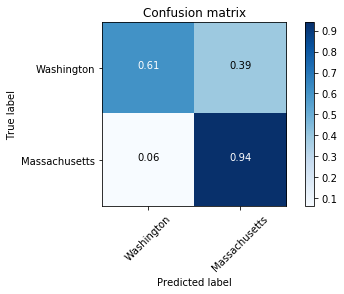

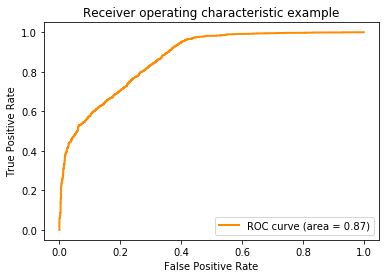

LSI with Min df = 5
Best Parameter :  {'C': 1000}
Precision Score:  0.734737593717
Recall Score:  0.941015089163
Accuracy Score:  0.786849181129
Normalized confusion matrix
[[ 0.60976891  0.39023109]
 [ 0.05898491  0.94101509]]


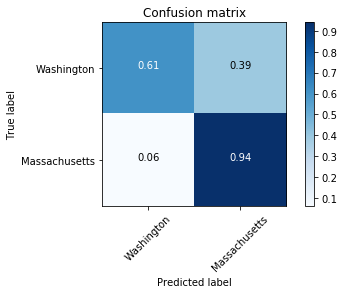

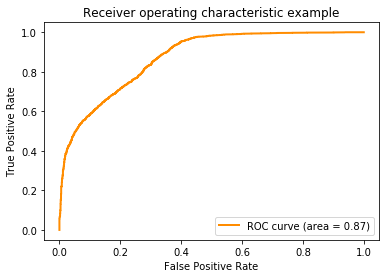

NMF with Min df = 2
Best Parameter :  {'C': 1000}
Precision Score:  0.733879586747
Recall Score:  0.941929583905
Accuracy Score:  0.786360303104
Normalized confusion matrix
[[ 0.60766807  0.39233193]
 [ 0.05807042  0.94192958]]


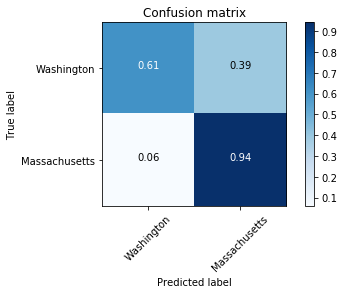

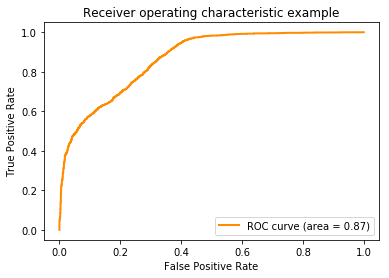

NMF with Min df = 5
Best Parameter :  {'C': 10}
Precision Score:  0.732334047109
Recall Score:  0.938271604938
Accuracy Score:  0.783671473967
Normalized confusion matrix
[[ 0.60609244  0.39390756]
 [ 0.0617284   0.9382716 ]]


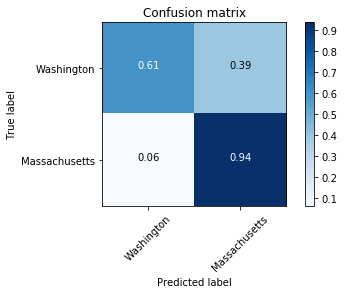

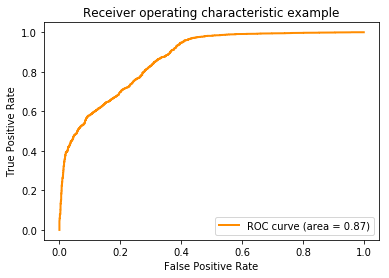

In [40]:
perform_LR("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test,'l2')
perform_LR("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test,'l2')
perform_LR("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test,'l2')
perform_LR("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test,'l2')

### Random Forest Classifier

In [41]:
def perform_RF(title,X_train,y_train,X_test,y_test):
    print(title)
    parameters = {'n_estimators':[10,20,30,40,50]}
    clf = GridSearchCV(RandomForestClassifier(), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    rf = RandomForestClassifier(n_estimators=best_param)
    rf.fit(X_train,y_train)
    preds = rf.predict(X_test)
    y_score = rf.predict_proba(X_test)
    performance_metrics(preds,y_test,y_score[:,1])

LSI with Min df = 2
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.753007217322
Recall Score:  0.858710562414
Accuracy Score:  0.773893913469
Normalized confusion matrix
[[ 0.67647059  0.32352941]
 [ 0.14128944  0.85871056]]


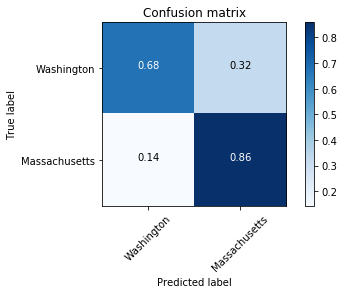

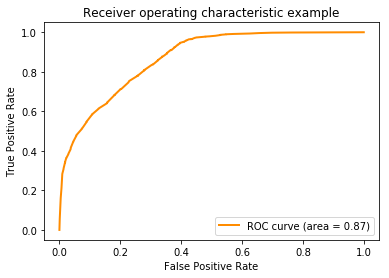

LSI with Min df = 5
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.753594249201
Recall Score:  0.862825788752
Accuracy Score:  0.775849425568
Normalized confusion matrix
[[ 0.67594538  0.32405462]
 [ 0.13717421  0.86282579]]


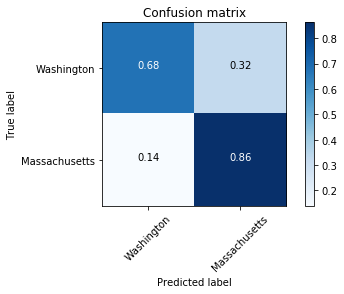

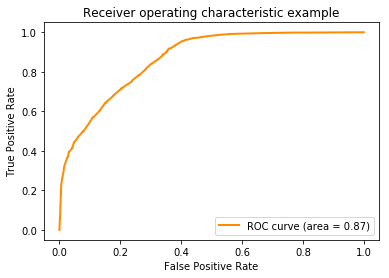

NMF with Min df = 2
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.767497988737
Recall Score:  0.872427983539
Accuracy Score:  0.790515766316
Normalized confusion matrix
[[ 0.69642857  0.30357143]
 [ 0.12757202  0.87242798]]


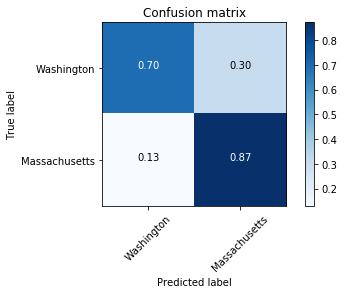

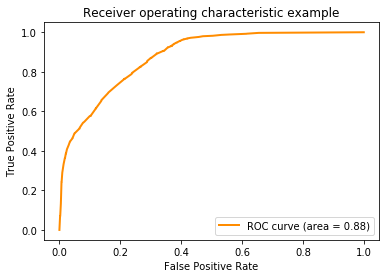

NMF with Min df = 5
Best Parameter :  {'n_estimators': 50}
Precision Score:  0.762149348084
Recall Score:  0.882030178326
Accuracy Score:  0.789782449279
Normalized confusion matrix
[[ 0.68382353  0.31617647]
 [ 0.11796982  0.88203018]]


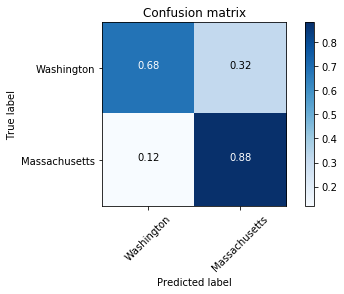

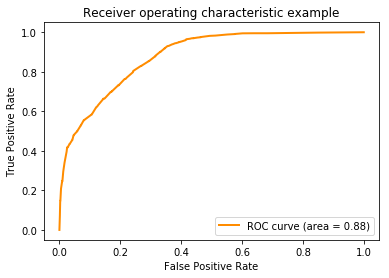

In [42]:
perform_RF("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test)
perform_RF("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test)
perform_RF("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test)
perform_RF("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test)

### Neural Network Classifier

In [43]:
def perform_NN(title,X_train,y_train,X_test,y_test):
    print(title)
    parameters = {'activation' : ['identity', 'logistic', 'tanh', 'relu']}
    clf = GridSearchCV(MLPClassifier(), parameters, cv=5)
    clf.fit(X_train,y_train)
    print("Best Parameter : ",clf.best_params_)
    best_param = list(clf.best_params_.values())[0]
    mlp = MLPClassifier(activation=best_param)
    mlp.fit(X_train,y_train)
    preds = mlp.predict(X_test)
    y_score = mlp.predict_proba(X_test)
    performance_metrics(preds,y_test,y_score[:,1])

LSI with Min df = 2
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.738599640934
Recall Score:  0.940557841792
Accuracy Score:  0.790271327304
Normalized confusion matrix
[[ 0.61764706  0.38235294]
 [ 0.05944216  0.94055784]]


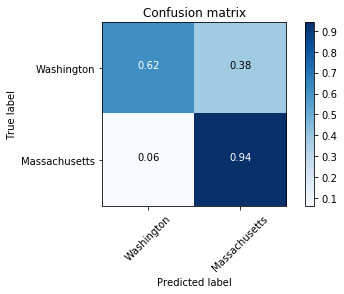

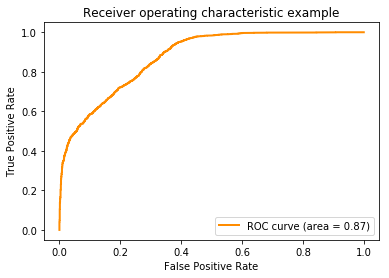

LSI with Min df = 5
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.736156351792
Recall Score:  0.930041152263
Accuracy Score:  0.784404791005
Normalized confusion matrix
[[ 0.61712185  0.38287815]
 [ 0.06995885  0.93004115]]


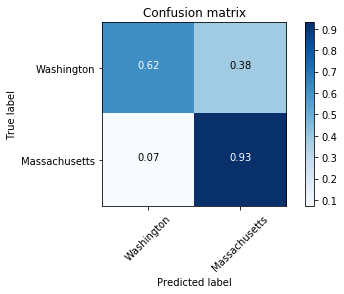

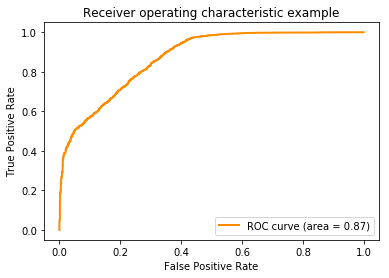

NMF with Min df = 2
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.73892519971
Recall Score:  0.930498399634
Accuracy Score:  0.787093620142
Normalized confusion matrix
[[ 0.62237395  0.37762605]
 [ 0.0695016   0.9304984 ]]


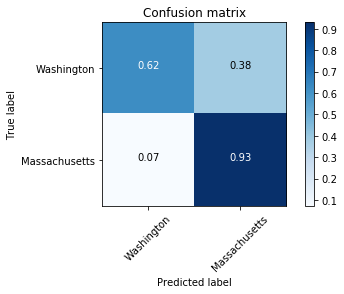

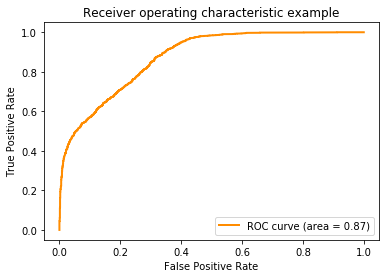

NMF with Min df = 5
Best Parameter :  {'activation': 'relu'}
Precision Score:  0.735652797704
Recall Score:  0.937814357567
Accuracy Score:  0.786604742117
Normalized confusion matrix
[[ 0.61292017  0.38707983]
 [ 0.06218564  0.93781436]]


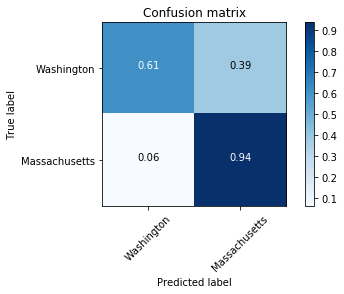

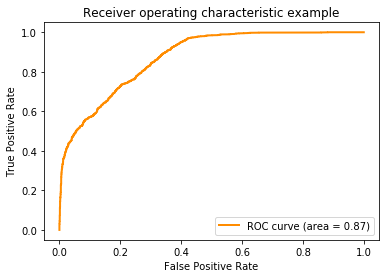

In [44]:
perform_NN("LSI with Min df = 2",svd_train_2,y_train,svd_test_2,y_test)
perform_NN("LSI with Min df = 5",svd_train_5,y_train,svd_test_5,y_test)
perform_NN("NMF with Min df = 2",nmf_train_2,y_train,nmf_test_2,y_test)
perform_NN("NMF with Min df = 5",nmf_train_5,y_train,nmf_test_5,y_test)